# Selektivní zesílení hledaného vzoru signálu

Předpokládáme, že vzor hledaného signálu známe (kolečko nebo křižek v piškvorkách), v datech je schovaný v šumu srovnatelné intenzity.

Takový signál ale pořád se vzorem slabě koreluje. To dává základní indicii, že by tam mohl být. 

Seriozní analýza by tady chtěla alespoň základní statistický test na vyloučení chyby 1. druhu (falešné pozitivum); to tady zatím není.

Následuje empiricky funční magie -- maskou vzoru signál v přílušných místech zesílíme; tím sice nabyde i šum, ten ale následně lze odstranit konvolucí.

In [587]:
import numpy as np
import matplotlib.pyplot as plt

# základní rozlišení (původně zamýšlený poloměr kruhu, to uplně nevyšlo ...) 
R = 30

# šum na pozadí, \sigma = 0.2 udělá šum viditelně v rozmezí [-1,1]
bg = np.random.normal(size=(3*R,3*R),scale=.2)

# společné paramatry pro obrázky
sopt = { 'cmap' : 'coolwarm', 'vmin' : -1., 'vmax' : 1. }

In [588]:
# vzorové piškvorkové obrázky
x = np.tile(np.linspace(-1.,1,3*R),(3*R,1))
y = x.T
 
circ = np.sqrt(x*x + y*y)-.5
circ *= circ
circ = np.exp(-1000.*circ)

cross = np.abs(x)-np.abs(y)
cross *= cross
cross = np.exp(-1000.*cross)
cross *= .71-(x*x + y*y)
cross[cross < 0.] = 0.
cross *= 1.4

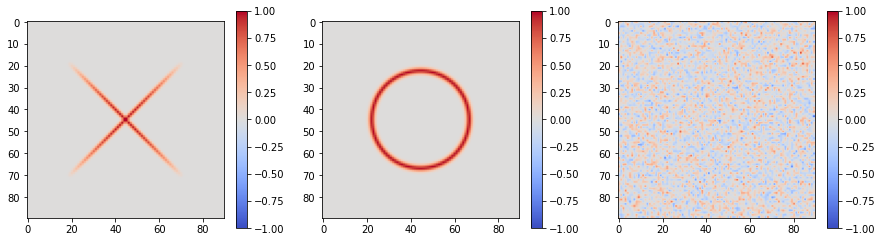

In [589]:
# a raději si je ukážeme (a šum taky)
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(cross,**sopt)
plt.colorbar()
plt.subplot(132)
plt.imshow(circ,**sopt)
plt.colorbar()
plt.subplot(133)
plt.imshow(bg,**sopt)
plt.colorbar()
plt.show()

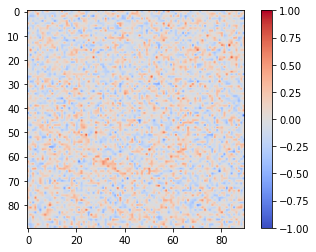

In [590]:
# uříznutá polovina kolečka
halfcirc = circ.copy()
halfcirc[y < 0.] = 0.

# a ta druhá
uphalfcirc = circ.copy()
uphalfcirc[y > 0.] = 0

# náš "experiment" je mix šumu a slabě viditelná půlka kolečka
mix = .2*halfcirc+bg

plt.imshow(mix,**sopt)
plt.colorbar()
plt.show()
# našli, rádcové, našli?

## Korelace

A teď to zajímavé -- jak se projeví korelace zašuměného slabého signálu s hledaným vzorem?

In [591]:
# technická obálka, np.corrcoef() je univerzálnější
def cor(a,b):
    return np.corrcoef(a.flatten(),b.flatten())[0][1]

In [592]:
# vzor proti šumu -- nic významného
cor(circ,bg)

-0.006343067428325808

In [593]:
# i když to není moc, i slabá polovina kolečka vidět je
circ_mix = cor(circ,mix)
circ_mix

0.07735260934882536

In [594]:
# křížek tam nenajdeme
cross_mix = cor(cross,mix)
cross_mix

0.00027126953639748587

In [595]:
# "správná" polovina kolečka by byla výrazně silnější
cor(halfcirc,mix)

0.1191313197277779

In [596]:
# nesprávná naopak srovnatelná s šumem 
cor(uphalfcirc,mix)

-0.011469159525174293

## Zesílení signálu

Magie začíná.

Z korelace víme, co asi tak hledáme. Oblast, kde by se signál měl nacházet, tedy uměle zesílíme (úměrně korelaci).

Výsledek srovnáváme s původním experimentem a experimentem zesíleným v celé oblasti.
Dle očekávání, tam kde signál je, objeví se silněji, ale stejně tak se zesílí šum (v obou případech).

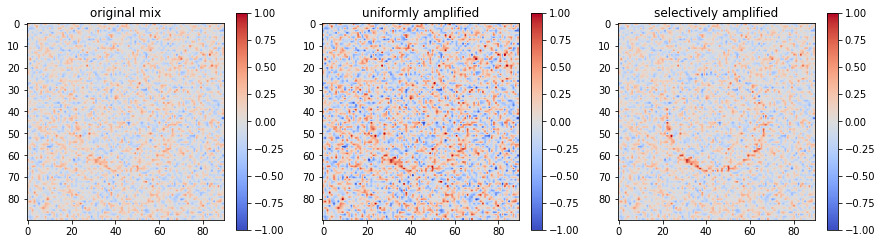

In [597]:
boost = 10.
amp = mix*(1.+(circ*circ_mix+cross*cross_mix)*boost)

plt.figure(figsize=(15,4))
plt.subplot(131).set_title('original mix')
plt.imshow(mix,**sopt)
plt.colorbar()
plt.subplot(132).set_title('uniformly amplified')
plt.imshow(mix * (circ_mix*boost+1.),**sopt)
plt.colorbar()
plt.subplot(133).set_title('selectively amplified')
plt.imshow(amp,**sopt)
plt.colorbar()
plt.show()

## Kontrola korelací

In [598]:
# Se selektivně zesíleným signálem je to citelně lepší
cor(circ,amp)

0.11989635644945412

In [599]:
# zdánlivě se vylepšila i "přítomnost" křížku, ale stále pod prahem čehokoli významného
cor(cross,amp)

0.004048242351483314

In [600]:
# správná polovina kolečka je také lepší
cor(halfcirc,amp)

0.1861611176620975

In [601]:
# špatná pořád mimo
cor(uphalfcirc,amp)

-0.019285031070642118

In [602]:
# a kolečko vůči celkově zesílenému experimentu by bylo pořád stejně; tedy selektivní zesílení skutečně pomohlo
cor(circ,mix * (1. + circ_mix * boost))

0.07735260934882535

## Konvoluce

Problém předchozího zesílení je oblast vzoru, kde skutečný signál není (horní půlka kolečka). 

To ale dokážeme "zamáznout" konvolucí. Náhodný šum se zruší, signál už je výrazně viditelný. Konvoluce samozřejmě také (díky prostorové souvislosti) pomůže na původních datech, ale ne tak výrazně.

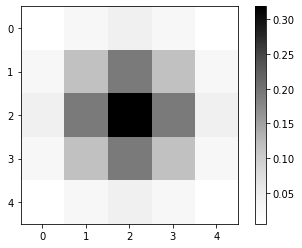

In [603]:
Rk = 5
xk = np.tile(np.linspace(-1.,1,Rk),(Rk,1))
yk = xk.T
kern = np.exp(-2.*(xk*xk+yk*yk))
kern *= 1./np.sum(kern*kern)
plt.imshow(kern,cmap='Greys')
plt.colorbar()
plt.show()

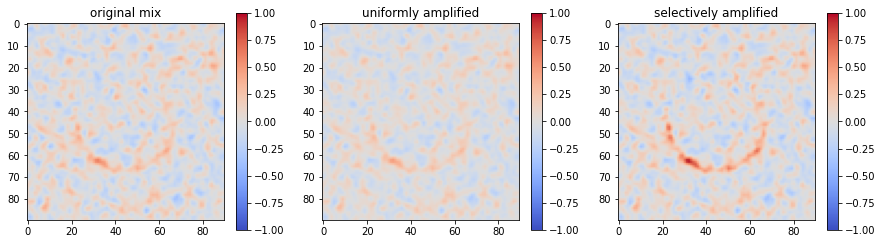

In [604]:
from scipy import signal
mix_conv = signal.convolve2d(mix, kern, boundary='fill', mode='same')
mix2_conv = signal.convolve2d(mix * circ_mix * boost, kern, boundary='fill', mode='same')
amp_conv = signal.convolve2d(amp, kern, boundary='fill', mode='same')
plt.figure(figsize=(15,4))
plt.subplot(131).set_title('original mix')
plt.imshow(mix_conv,**sopt)
plt.colorbar()
plt.subplot(132).set_title('uniformly amplified')
plt.imshow(mix2_conv,**sopt)
plt.colorbar()
plt.subplot(133).set_title('selectively amplified')
plt.imshow(amp_conv,**sopt)
plt.colorbar()
plt.show()

In [605]:
# a tohle uz je dost presvedcive
cor(circ,amp_conv)

0.30541111602430415

In [606]:
# zlepšilo se i na nezesílených datech, ale ne tolik
cor(circ,mix_conv)

0.21229313938731362

In [607]:
# a celkové zesílení opět nepomůže
cor(circ,mix2_conv)

0.21229313938731362